In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches


# Load the CSV file (already done in your code)
#--stepwise
csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_Existing.csv"
Air_Emissions_County_Level_Existing = pd.read_csv(csv_path)

csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_New.csv"
Air_Emissions_County_Level_New = pd.read_csv(csv_path)

#--rep days

# Merge the two dataframes
# Combine the dataframes (rbind equivalent in R is concat in pandas)
Air_Emissions_County_Level = pd.concat([Air_Emissions_County_Level_Existing, Air_Emissions_County_Level_New], ignore_index=True)

new_england_states = ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut"]
new_england_state_codes = ["ME", "NH", "VT", "MA", "RI", "CT"]
new_england_state_id = ["23", "33", "50", "25", "44", "09"]

# Load a shapefile or GeoJSON of U.S. counties
# Use GeoPandas to read a GeoJSON file with New England county geometries
county_boundaries_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Census Geo Data/New_England_county_boundaries.json"  # Replace with the actual path
county_boundaries = gpd.read_file(county_boundaries_path)
state_code_to_id = dict(zip(new_england_state_id, new_england_state_codes))
# Add the state_id column
county_boundaries["State"] = county_boundaries["state"].map(state_code_to_id)
county_boundaries['County'] = county_boundaries['name'] 

# Filter state boundaries to include only New England  states
state_boundaries_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Census Geo Data/US.json"  # Replace with the actual path
state_boundaries = gpd.read_file(state_boundaries_path)
state_boundaries = state_boundaries[state_boundaries['name'].isin(new_england_states)]

In [19]:
# Summarize data
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level.groupby(
    ['County', 'State', 'Pathway', 'Simulation']
).agg({
    'npv_total_air_emission_USD': 'sum',
    'mortality_person': 'sum',
    'npv_NOx_USD': 'sum',
    'npv_SO2_USD': 'sum',
    'npv_PM2.5_USD': 'sum',
    'npv_PM10_USD': 'sum',
    'npv_CO_USD': 'sum',
    'npv_VOC_USD': 'sum'
}).reset_index()

Air_Emissions_County_Level_Summary = Air_Emissions_County_Level_Summary.groupby(
    ['County', 'State', 'Pathway']
).agg({
    'npv_total_air_emission_USD': 'mean',
    'mortality_person': 'mean',
    'npv_NOx_USD': 'mean',
    'npv_SO2_USD': 'mean',
    'npv_PM2.5_USD': 'mean',
    'npv_PM10_USD': 'mean',
    'npv_CO_USD': 'mean',
    'npv_VOC_USD': 'mean'
}).reset_index()

In [20]:
# Merge emissions data with county geometries
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level_Summary.merge(county_boundaries, on=['County', 'State'], how='left')

# Categorize npv_total_air_emission_USD for visual differentiation
def categorize_emissions(value):
    if value <= 1e5:
        return "0-100K"
    elif value <= 5e5:
        return "100K-500K"
    elif value <= 1e6:
        return "500K-1M"
    elif value <= 2e6:
        return "1M-2M"
    elif value <= 5e6:
        return "2M-5M"
    elif value <= 10e6:
        return "5M-10M"
    else:
        return ">10M"


# Replace missing values in 'npv_total_air_emission_USD' with 0
Air_Emissions_County_Level_Summary['emission_category'] = Air_Emissions_County_Level_Summary['npv_total_air_emission_USD'].apply(categorize_emissions)

#Ensure data is gpd
Air_Emissions_County_Level_Summary = gpd.GeoDataFrame(
    Air_Emissions_County_Level_Summary,
    geometry='geometry'
)

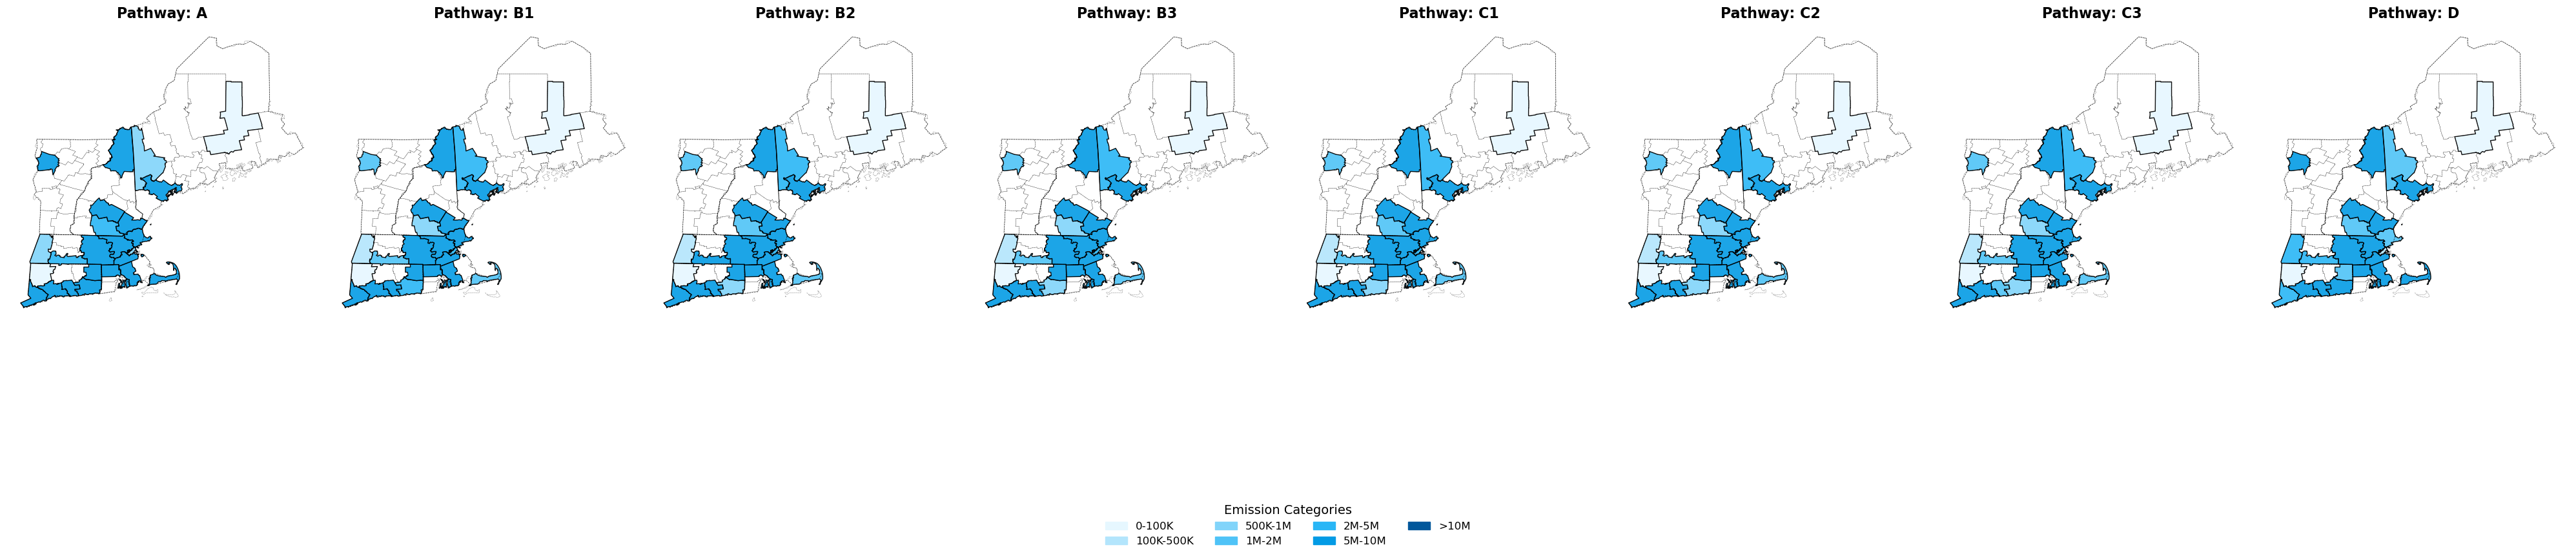

In [21]:
# Define improved color mapping

category_colors = {
    "0-100K": "#e6f7ff",      # Very light blue
    "100K-500K": "#b3e5fc",   # Light blue
    "500K-1M": "#81d4fa",     # Medium blue
    "1M-2M": "#4fc3f7",       # Intense blue
    "2M-5M": "#29b6f6",       # Deep blue
    "5M-10M": "#039be5",      # Dark blue
    ">10M": "#01579b"
}

# Create a custom colormap
custom_cmap = ListedColormap(list(category_colors.values())[:-1])  # Exclude "No Data"

# Create legend patches
legend_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in category_colors.items()
]

# Get unique pathways
unique_pathways = Air_Emissions_County_Level_Summary['Pathway'].unique()

# Create subplots for each pathway in one row
fig, axes = plt.subplots(1, len(unique_pathways), figsize=(40, 10), sharex=True, sharey=True)

# Loop through each pathway and create a plot
for ax, pathway in zip(axes, unique_pathways):
    filtered_df = Air_Emissions_County_Level_Summary[
        Air_Emissions_County_Level_Summary['Pathway'] == pathway
    ]
    
    # Add state boundaries with a distinct style
    state_boundaries.boundary.plot(ax=ax, color="black", linestyle="--", linewidth=0.5, alpha=0.8)
    
    # Add county boundaries with subtle styling
    county_boundaries.boundary.plot(ax=ax, color="black", linestyle="--", linewidth=0.2)
    

    # Plot the data using the custom colormap
    filtered_df.plot(
        ax=ax,
        column='emission_category',
        cmap=custom_cmap,
        legend=False,  # Legend will be added separately
        alpha=0.9,
        edgecolor="black"
    )
    
    # Set title for each subplot
    ax.set_title(f"Pathway: {pathway}", fontsize=16, fontweight="bold")
    ax.set_axis_off()

# Add a single legend for all plots
fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=4,
    fontsize=12,
    frameon=False,
    title="Emission Categories",
    title_fontsize=14
)

# Adjust spacing and display the plot
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)  # Adjust space for legend
plt.show()


## Comparing pathways


In [22]:
Air_Emissions_County_Level

,County,State,Simulation,Pathway,npv_NOx_USD,npv_SO2_USD,npv_PM2.5_USD,npv_PM10_USD,npv_CO_USD,npv_VOC_USD,npv_total_air_emission_USD,mortality_person
0,Suffolk,MA,1,A,22793.224008,37492.648362,1.295514e+06,88952.401015,2.720445e+05,72532.871796,1.789329e+06,0.229978
1,Suffolk,MA,1,B1,6602.097233,10859.811229,3.752473e+05,25765.184221,7.879807e+04,21009.245198,5.182817e+05,0.050472
2,Suffolk,MA,1,B2,6616.677115,10883.793723,3.760760e+05,25822.086668,7.897209e+04,21055.644146,5.194263e+05,0.050585
3,Suffolk,MA,1,B3,6604.516512,10863.790708,3.753848e+05,25774.626044,7.882694e+04,21016.944176,5.184716e+05,0.050490
4,Suffolk,MA,1,C1,6690.328736,11004.943515,3.802623e+05,26109.528319,7.985118e+04,21290.027572,5.252083e+05,0.051163
...,...,...,...,...,...,...,...,...,...,...,...,...
2386,Rockingham,NH,472,D,79585.690159,319868.905033,8.111580e+06,0.000000,4.560393e+06,182684.735245,1.325411e+07,2.167846
2387,Rockingham,NH,481,D,79585.690159,319868.905033,8.111580e+06,0.000000,4.560393e+06,182684.735245,1.325411e+07,2.167846
2388,Rockingham,NH,482,D,79585.690159,319868.905033,8.111580e+06,0.000000,4.560393e+06,182684.735245,1.325411e+07,2.167846
2389,Rockingham,NH,491,D,79585.690159,319868.905033,8.111580e+06,0.000000,4.560393e+06,182684.735245,1.325411e+07,2.167846


In [23]:
import pandas as pd

# First GroupBy: Summing emissions and mortality per County, State, Pathway, and Simulation
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level.groupby(
    ['County', 'State', 'Pathway', 'Simulation']
).agg({
    'npv_total_air_emission_USD': 'sum',
    'mortality_person': 'sum',
    'npv_NOx_USD': 'sum',
    'npv_SO2_USD': 'sum',
    'npv_PM2.5_USD': 'sum',
    'npv_PM10_USD': 'sum',
    'npv_CO_USD': 'sum',
    'npv_VOC_USD': 'sum'
}).reset_index()

# Second GroupBy: Calculating mean, max, and min for specific columns per County, State, and Pathway
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level_Summary.groupby(
    ['County', 'State', 'Pathway']
).agg(
    npv_total_air_emission_USD_mean=('npv_total_air_emission_USD', 'mean'),
    mortality_person_mean=('mortality_person', 'mean'),
    npv_total_air_emission_USD_max=('npv_total_air_emission_USD', 'max'),
    mortality_person_max=('mortality_person', 'max'),
    npv_total_air_emission_USD_min=('npv_total_air_emission_USD', 'min'),
    mortality_person_min=('mortality_person', 'min')
).reset_index()


In [24]:
Air_Emissions_County_Level_Summary

,County,State,Pathway,npv_total_air_emission_USD_mean,mortality_person_mean,npv_total_air_emission_USD_max,mortality_person_max,npv_total_air_emission_USD_min,mortality_person_min
0,Barnstable,MA,A,1.737449e+07,2.258703,1.762189e+07,2.287692,1.720082e+07,2.237181
1,Barnstable,MA,B1,3.912667e+06,0.380394,4.021473e+06,0.390929,3.856404e+06,0.374798
2,Barnstable,MA,B2,4.107335e+06,0.399648,4.218864e+06,0.410377,4.036754e+06,0.392800
3,Barnstable,MA,B3,3.957187e+06,0.384842,4.069522e+06,0.395749,3.899040e+06,0.379060
4,Barnstable,MA,C1,4.697360e+06,0.458424,4.822189e+06,0.470502,4.620735e+06,0.451001
...,...,...,...,...,...,...,...,...,...
195,Worcester,MA,B3,9.915195e+06,1.134062,1.087016e+07,1.240497,9.279761e+06,1.065366
196,Worcester,MA,C1,1.232347e+07,1.278339,1.308474e+07,1.357910,1.175197e+07,1.218729
197,Worcester,MA,C2,1.228634e+07,1.390291,1.323598e+07,1.495858,1.167008e+07,1.323374
198,Worcester,MA,C3,8.844369e+06,0.994335,9.725076e+06,1.090655,8.258235e+06,0.931654


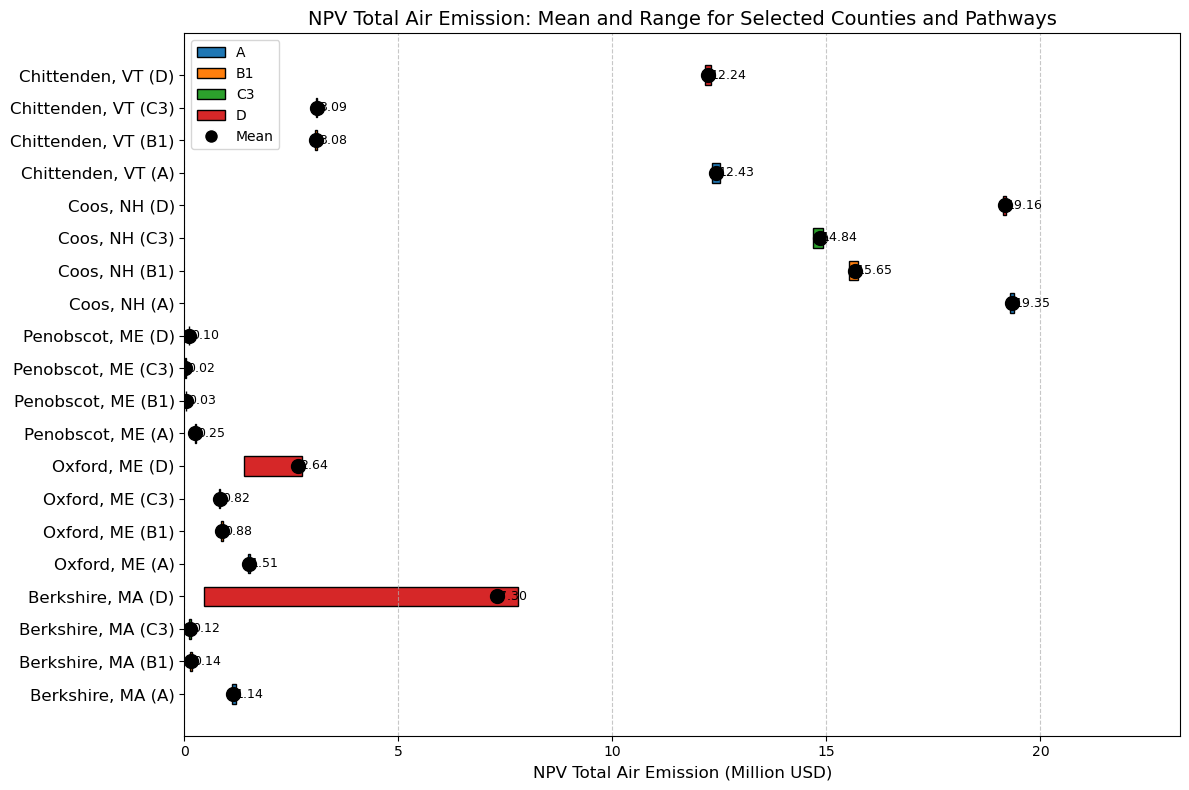

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming Air_Emissions_County_Level_Summary is your DataFrame
# Ensure it is already loaded in your environment

# Define the selected counties and their states
selected_counties = [
    ('Coos', 'NH'),
    ('Berkshire', 'MA'),   # Replaced 'Carroll, NH' with 'Berkshire, MA'
    ('Penobscot', 'ME'),
    ('Oxford', 'ME'),
    ('Chittenden', 'VT')
]

# List of selected pathways
selected_pathways = ['A', 'D', 'B1', 'C3']

# Convert the list of tuples to a set for efficient filtering
selected_set = set(selected_counties)

# Filter the DataFrame to include only the selected counties and pathways
filtered_df = Air_Emissions_County_Level_Summary[
    Air_Emissions_County_Level_Summary[['County', 'State']].apply(tuple, axis=1).isin(selected_set) &
    Air_Emissions_County_Level_Summary['Pathway'].isin(selected_pathways)
].copy()

# Check if the filtered DataFrame is empty
if filtered_df.empty:
    raise ValueError("No data found for the selected counties and pathways. Please check the county names, states, and pathways.")

# Aggregate the data per county and pathway to get overall min, max, and mean
aggregated_df = filtered_df.groupby(['County', 'State', 'Pathway']).agg(
    npv_total_air_emission_USD_mean_mill=('npv_total_air_emission_USD_mean', 'mean'),
    npv_total_air_emission_USD_min_mill=('npv_total_air_emission_USD_min', 'min'),
    npv_total_air_emission_USD_max_mill=('npv_total_air_emission_USD_max', 'max')
).reset_index()

# Convert USD to Million USD
aggregated_df['npv_total_air_emission_USD_mean_mill'] = aggregated_df['npv_total_air_emission_USD_mean_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_min_mill'] = aggregated_df['npv_total_air_emission_USD_min_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_max_mill'] = aggregated_df['npv_total_air_emission_USD_max_mill'] / 1e6

# Create a unique identifier for each County and Pathway
aggregated_df['County_Pathway'] = aggregated_df['County'] + ', ' + aggregated_df['State'] + ' (' + aggregated_df['Pathway'] + ')'

# Optional: Sort the DataFrame for better visualization
aggregated_df.sort_values(['State', 'County', 'Pathway'], inplace=True)

# Set the figure size
plt.figure(figsize=(12, 8))

# Number of entries
num_entries = len(aggregated_df)

# Create a range for y-axis positions
y_positions = np.arange(num_entries)

# Define a color palette for pathways using a colormap
pathway_unique = aggregated_df['Pathway'].unique()
colors = plt.cm.tab10.colors  # Tab10 has 10 distinct colors
pathway_colors = {pathway: colors[i % len(colors)] for i, pathway in enumerate(pathway_unique)}

# Assign colors based on Pathway
aggregated_df['Color'] = aggregated_df['Pathway'].map(pathway_colors)

# Plot the range as horizontal bars
plt.barh(
    y_positions,
    aggregated_df['npv_total_air_emission_USD_max_mill'] - aggregated_df['npv_total_air_emission_USD_min_mill'],
    left=aggregated_df['npv_total_air_emission_USD_min_mill'],
    color=aggregated_df['Color'],
    edgecolor='black',
    height=0.6,
    label='Range'
)

# Plot the mean values as dots
plt.scatter(
    aggregated_df['npv_total_air_emission_USD_mean_mill'],
    y_positions,
    color='black',
    marker='o',
    s=100,  # Size of the dots
    label='Mean'
)

# Add numerical labels to the mean dots using positional index
for pos, row in enumerate(aggregated_df.itertuples(index=False)):
    plt.text(
        row.npv_total_air_emission_USD_mean_mill + 0.05,  # Slightly offset to the right
        y_positions[pos],
        f"{row.npv_total_air_emission_USD_mean_mill:.2f}",
        va='center',
        fontsize=9
    )

# Set y-ticks and labels
plt.yticks(y_positions, aggregated_df['County_Pathway'], fontsize=12)

# Labeling
plt.xlabel('NPV Total Air Emission (Million USD)', fontsize=12)
plt.title('NPV Total Air Emission: Mean and Range for Selected Counties and Pathways', fontsize=14)

# Add vertical grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create custom legend for Pathways
legend_elements = [Patch(facecolor=color, edgecolor='black', label=pathway) 
                   for pathway, color in pathway_colors.items()]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Mean',
                                  markerfacecolor='black', markersize=10))

plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Adjust x-axis limits to add some space on the right
plt.xlim(0, aggregated_df['npv_total_air_emission_USD_max_mill'].max() * 1.2)  # 20% extra space

# Improve layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()


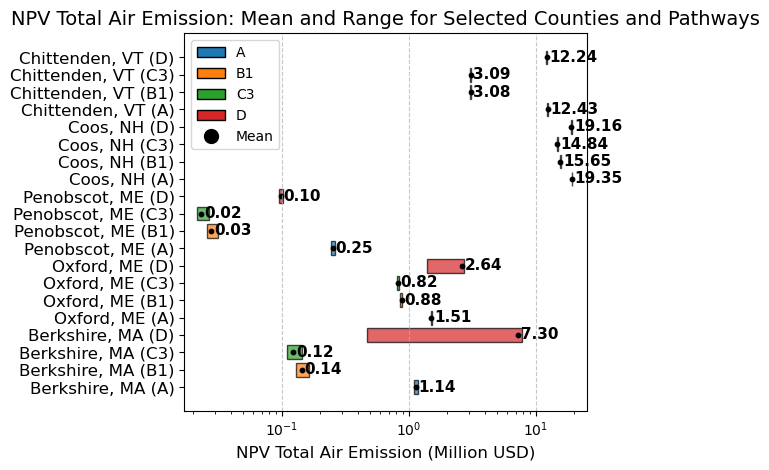

In [26]:
# ... [Previous Code] ...

# Set x-axis to logarithmic scale
plt.xscale('log')

# Plot the range as horizontal bars with increased height and transparency
plt.barh(
    y_positions,
    aggregated_df['npv_total_air_emission_USD_max_mill'] - aggregated_df['npv_total_air_emission_USD_min_mill'],
    left=aggregated_df['npv_total_air_emission_USD_min_mill'],
    color=aggregated_df['Color'],
    edgecolor='black',
    height=0.8,  # Increased height
    alpha=0.7,    # Semi-transparent
    label='Range'
)

# Plot the mean values as larger dots
plt.scatter(
    aggregated_df['npv_total_air_emission_USD_mean_mill'],
    y_positions,
    color='black',
    marker='o',
    s=10,  # Increased size
    label='Mean'
)

# Add numerical labels with a larger font size
for pos, row in enumerate(aggregated_df.itertuples(index=False)):
    plt.text(
        row.npv_total_air_emission_USD_mean_mill * 1.05,  # Slightly offset to the right
        y_positions[pos],
        f"{row.npv_total_air_emission_USD_mean_mill:.2f}",
        va='center',
        fontsize=11,
        fontweight='bold'
    )

# Set y-ticks and labels
plt.yticks(y_positions, aggregated_df['County_Pathway'], fontsize=12)

# Labeling
plt.xlabel('NPV Total Air Emission (Million USD)', fontsize=12)
plt.title('NPV Total Air Emission: Mean and Range for Selected Counties and Pathways', fontsize=14)

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create custom legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=pathway) 
                   for pathway, color in pathway_colors.items()]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Mean',
                                  markerfacecolor='black', markersize=12))
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Adjust x-axis limits with a small buffer on both sides
plt.xlim(aggregated_df['npv_total_air_emission_USD_min_mill'].min() * 0.8, 
         aggregated_df['npv_total_air_emission_USD_max_mill'].max() * 1.3)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


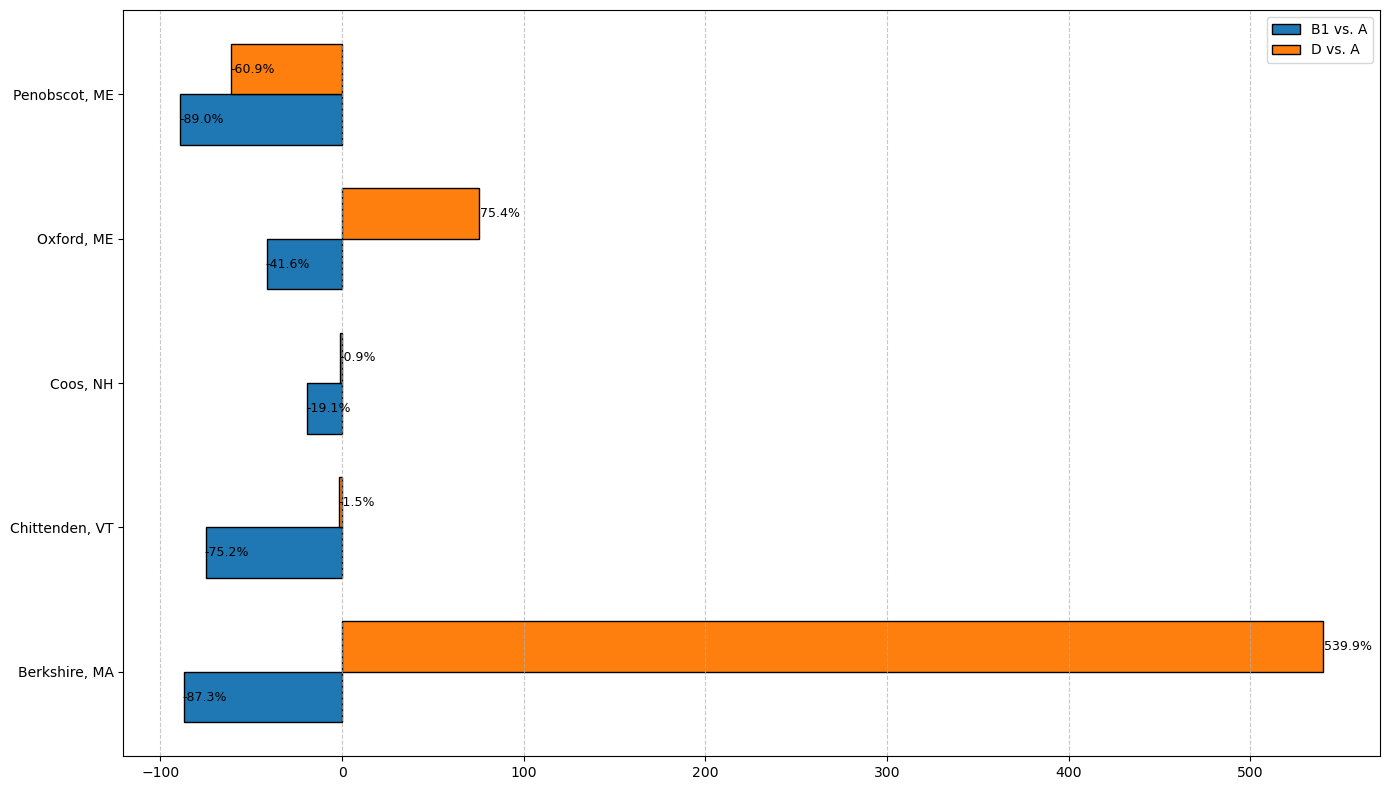

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming Air_Emissions_County_Level_Summary is your DataFrame
# Ensure it is already loaded in your environment

# Define the selected counties and their states
selected_counties = [
    ('Coos', 'NH'),
    ('Berkshire', 'MA'),    # Replaced 'Carroll, NH' with 'Berkshire, MA'
    ('Penobscot', 'ME'),
    ('Oxford', 'ME'),
    ('Chittenden', 'VT'),
    ('Carroll', 'NH')
]

# List of selected pathways
selected_pathways = ['A', 'D', 'B1', 'C3']

# Convert the list of tuples to a set for efficient filtering
selected_set = set(selected_counties)

# Filter the DataFrame to include only the selected counties and pathways
filtered_df = Air_Emissions_County_Level_Summary[
    Air_Emissions_County_Level_Summary[['County', 'State']].apply(tuple, axis=1).isin(selected_set) &
    Air_Emissions_County_Level_Summary['Pathway'].isin(selected_pathways)
].copy()

# Check if the filtered DataFrame is empty
if filtered_df.empty:
    raise ValueError("No data found for the selected counties and pathways. Please check the county names, states, and pathways.")

# Aggregate the data per county and pathway to get overall mean emission
aggregated_df = filtered_df.groupby(['County', 'State', 'Pathway']).agg(
    npv_total_air_emission_USD_mean_mill=('npv_total_air_emission_USD_mean', 'mean')
).reset_index()

# Convert USD to Million USD
aggregated_df['npv_total_air_emission_USD_mean_mill'] = aggregated_df['npv_total_air_emission_USD_mean_mill'] / 1e6

# Create a unique identifier for each County and Pathway
aggregated_df['County_Pathway'] = (
    aggregated_df['County'] + ', ' +
    aggregated_df['State'] + ' (' +
    aggregated_df['Pathway'] + ')'
)

# Optional: Sort the DataFrame for better visualization
aggregated_df.sort_values(['State', 'County', 'Pathway'], inplace=True)

# Pivot the DataFrame to have pathways as columns
pivot_df = aggregated_df.pivot_table(
    index=['County', 'State'],
    columns='Pathway',
    values='npv_total_air_emission_USD_mean_mill'
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None  # Remove the aggregation name
pivot_df.rename(columns={
    'A': 'A_mean',
    'B1': 'B1_mean',
    'D': 'D_mean'
}, inplace=True)

# Check for missing data
missing_data = pivot_df[
    pivot_df[['A_mean', 'B1_mean', 'D_mean']].isnull().any(axis=1)
]
if not missing_data.empty:
    print("The following counties are missing data for one or more pathways:")
    print(missing_data[['County', 'State']])
    raise ValueError("Incomplete data detected. Please ensure all selected counties have data for pathways A, B1, and D.")

# Calculate percentage differences
pivot_df['B1_vs_A_pct_diff'] = ((pivot_df['B1_mean'] - pivot_df['A_mean']) / pivot_df['A_mean']) * 100
pivot_df['D_vs_A_pct_diff'] = ((pivot_df['D_mean'] - pivot_df['A_mean']) / pivot_df['A_mean']) * 100

# Combine County and State for labeling
pivot_df['County_State'] = pivot_df['County'] + ', ' + pivot_df['State']

# Define the positions and width for the bars
bar_width = 0.35
indices = np.arange(len(pivot_df))

# Create the plot
plt.figure(figsize=(14, 8))

# Define colors for comparisons
comparison_colors = {
    'B1 vs. A': plt.cm.tab10(0),  # Blue
    'D vs. A': plt.cm.tab10(1)    # Orange
}

# Plot bars for B1 vs. A
plt.barh(
    indices - bar_width/2,
    pivot_df['B1_vs_A_pct_diff'],
    height=bar_width,
    color=comparison_colors['B1 vs. A'],
    edgecolor='black',
    label='B1 vs. A'
)

# Plot bars for D vs. A
plt.barh(
    indices + bar_width/2,
    pivot_df['D_vs_A_pct_diff'],
    height=bar_width,
    color=comparison_colors['D vs. A'],
    edgecolor='black',
    label='D vs. A'
)

# Add labels and title
#plt.xlabel('Percentage Difference (%)', fontsize=12)
#plt.ylabel('County', fontsize=12)
#plt.title('Percentage Difference in NPV Total Air Emission Compared to Pathway A', fontsize=14)

# Set y-ticks
plt.yticks(indices, pivot_df['County_State'], fontsize=10)

# Add horizontal grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Annotate bars with percentage differences
for i in range(len(pivot_df)):
    # B1 vs. A
    plt.text(
        pivot_df.loc[i, 'B1_vs_A_pct_diff'] + (0.5 if pivot_df.loc[i, 'B1_vs_A_pct_diff'] >=0 else -0.5),
        indices[i] - bar_width/2,
        f"{pivot_df.loc[i, 'B1_vs_A_pct_diff']:.1f}%",
        va='center',
        fontsize=9
    )
    # D vs. A
    plt.text(
        pivot_df.loc[i, 'D_vs_A_pct_diff'] + (0.5 if pivot_df.loc[i, 'D_vs_A_pct_diff'] >=0 else -0.5),
        indices[i] + bar_width/2,
        f"{pivot_df.loc[i, 'D_vs_A_pct_diff']:.1f}%",
        va='center',
        fontsize=9
    )

# Adjust layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()


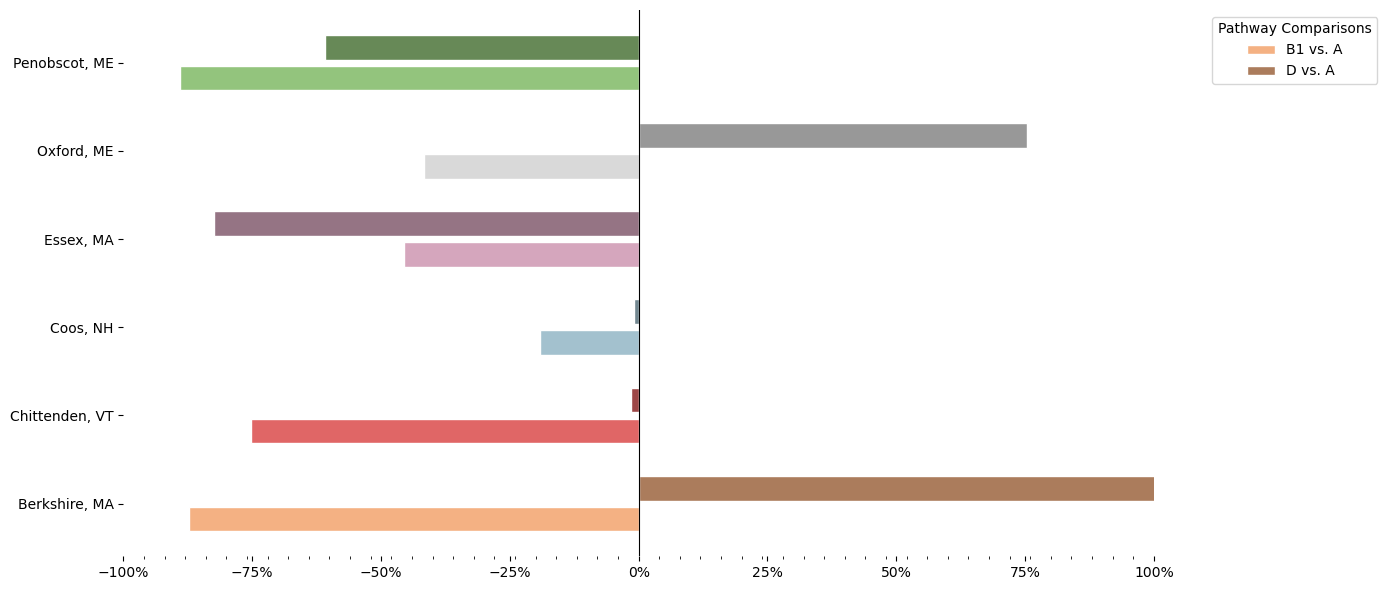

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, to_hex
import matplotlib.ticker as ticker

# Function to darken a color
def darken_color(color, amount=0.7):
    """
    Darken the given color by multiplying the RGB values by the given amount.
    """
    rgb = to_rgb(color)
    darkened = tuple(max(min(c * amount, 1), 0) for c in rgb)
    return darkened

# Assuming Air_Emissions_County_Level_Summary is your DataFrame
# Ensure it is already loaded in your environment

# Define the selected counties and their states
selected_counties = [
    ('Coos', 'NH'),
    ('Berkshire', 'MA'),
    ('Penobscot', 'ME'),
    ('Oxford', 'ME'),
    ('Chittenden', 'VT'),
    ('Carroll', 'NH'),
    ('Essex',	'MA')
]

# Pathway A is the baseline
baseline_pathway = 'A'

# Pathways to compare with A
comparison_pathways = ['B1', 'D']

# Define a list of pastel muted colors for the counties
# Ensure there are at least as many colors as there are counties
base_colors = [
    '#A3C1CE',  # Coos, NH - adjusted pastel blue
    '#F4B183',  # Berkshire, MA - adjusted pastel orange
    '#93C47D',  # Penobscot, ME - adjusted pastel green
    '#D9D9D9',  # Oxford, ME - adjusted pastel gray
    '#E06666',  # Chittenden, VT - adjusted pastel red
    '#D5A6BD',   # Carroll, NH - adjusted pastel pink
    '#D5A6BD'
]


# Create a mapping from County_State to base color
county_states = [f"{county}, {state}" for county, state in selected_counties]
county_color_map = {county_state: base_colors[i % len(base_colors)] for i, county_state in enumerate(county_states)}

# Convert the list of tuples to a set for efficient filtering
selected_set = set(selected_counties)

# Filter the DataFrame to include only the selected counties and the baseline and comparison pathways
filtered_df = Air_Emissions_County_Level_Summary[
    Air_Emissions_County_Level_Summary[['County', 'State']].apply(tuple, axis=1).isin(selected_set) &
    Air_Emissions_County_Level_Summary['Pathway'].isin([baseline_pathway] + comparison_pathways)
].copy()

# Check if the filtered DataFrame is empty
if filtered_df.empty:
    raise ValueError("No data found for the selected counties and pathways. Please check the county names, states, and pathways.")

# Aggregate the data per county and pathway to get overall mean emission
aggregated_df = filtered_df.groupby(['County', 'State', 'Pathway']).agg(
    npv_total_air_emission_USD_mean_mill=('npv_total_air_emission_USD_mean', 'mean'),
    npv_total_air_emission_USD_min_mill=('npv_total_air_emission_USD_min', 'min'),
    npv_total_air_emission_USD_max_mill=('npv_total_air_emission_USD_max', 'max')
).reset_index()

# Convert USD to Million USD for better readability
aggregated_df['npv_total_air_emission_USD_mean_mill'] = aggregated_df['npv_total_air_emission_USD_mean_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_min_mill'] = aggregated_df['npv_total_air_emission_USD_min_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_max_mill'] = aggregated_df['npv_total_air_emission_USD_max_mill'] / 1e6

# Optional: Sort the DataFrame for better visualization
aggregated_df.sort_values(['State', 'County', 'Pathway'], inplace=True)

# Pivot the DataFrame to have pathways as columns
pivot_df = aggregated_df.pivot_table(
    index=['County', 'State'],
    columns='Pathway',
    values='npv_total_air_emission_USD_mean_mill'
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None  # Remove the aggregation name
if baseline_pathway in pivot_df.columns:
    pivot_df.rename(columns={baseline_pathway: 'A_mean'}, inplace=True)
else:
    raise ValueError("Pathway A is not present in the data. It is required as the baseline for comparison.")

# Ensure only Pathways B1 and D are present
missing_comparisons = [pathway for pathway in comparison_pathways if pathway not in pivot_df.columns]
if missing_comparisons:
    # For missing comparison pathways, fill with zero to assume 100% reduction
    for pathway in missing_comparisons:
        pivot_df[pathway] = 0
    print(f"Warning: The following pathways were missing and have been filled with zero to assume 100% reduction: {', '.join(missing_comparisons)}")

# Fill missing Pathway A with zero to handle division by zero
pivot_df['A_mean'] = pivot_df['A_mean'].fillna(0)

# Fill missing comparison pathways with zero to assume 100% reduction
for pathway in comparison_pathways:
    if pathway not in pivot_df.columns:
        pivot_df[pathway] = 0
    else:
        pivot_df[pathway] = pivot_df[pathway].fillna(0)

# Calculate percentage differences of comparison pathways compared to A
for pathway in comparison_pathways:
    pivot_df[f'{pathway}_vs_A_pct_diff'] = np.where(
        pivot_df['A_mean'] == 0,
        -100,  # If A_mean is zero, assume 100% reduction
        ((pivot_df[pathway] - pivot_df['A_mean']) / pivot_df['A_mean']) * 100
    )

# Combine County and State for labeling
pivot_df['County_State'] = pivot_df['County'] + ', ' + pivot_df['State']

# Select only necessary columns for plotting
percentage_diff_df = pivot_df[['County_State'] + [f'{pathway}_vs_A_pct_diff' for pathway in comparison_pathways]].copy()

# Melt the DataFrame to have pathways as rows for easier plotting
percentage_diff_df = percentage_diff_df.melt(
    id_vars=['County_State'],
    value_vars=[f'{pathway}_vs_A_pct_diff' for pathway in comparison_pathways],
    var_name='Comparison',
    value_name='Percentage_Difference'
)

# Extract pathway names from the 'Comparison' column
percentage_diff_df['Pathway'] = percentage_diff_df['Comparison'].str.replace('_vs_A_pct_diff', '')

# Sort the DataFrame for better visualization
percentage_diff_df.sort_values(['County_State', 'Pathway'], inplace=True)

# Define unique pathways for consistent coloring
unique_pathways = sorted(percentage_diff_df['Pathway'].unique())

# Define color map using the updated method to avoid deprecation warning
color_map = plt.get_cmap('tab10')  # Updated to use plt.get_cmap instead of plt.cm.get_cmap

# Create a list of colors based on county and pathway
# Each county has a base color; Pathway D is a darker shade
colors = []
for _, row in pivot_df.iterrows():
    county_state = row['County_State']
    base_color = county_color_map[county_state]
    for pathway in comparison_pathways:
        if pathway == 'B1':
            colors.append(base_color)
        elif pathway == 'D':
            colors.append(to_hex(darken_color(base_color, 0.7)))  # Darken the base color for D
        else:
            colors.append('gray')  # Default color, should not occur

# Define the positions and height for the bars
bar_height = 0.35  # Adjust based on the number of pathways
indices = np.arange(len(pivot_df))

# Create the plot
plt.figure(figsize=(14, 6))

# Plot each pathway as a separate set of bars
for i, pathway in enumerate(comparison_pathways):
    # Calculate the position offset
    offset = (i - 0.5) * bar_height
    # Extract the percentage differences for the pathway
    pct_diff = pivot_df[f'{pathway}_vs_A_pct_diff']
    # Assign colors for the pathway
    pathway_colors_plot = [colors[j * len(comparison_pathways) + i] for j in range(len(pivot_df))]
    # Plot the horizontal bars
    plt.barh(
        indices + offset,
        pct_diff,
        height=bar_height * 0.8,  # Slightly less than bar_height for spacing
        color=pathway_colors_plot,
        edgecolor='white',
        label=f'{pathway} vs. A'
    )

# Add labels and title
#plt.xlabel('Percentage Difference (%)', fontsize=12)
#plt.ylabel('County', fontsize=12)
#plt.title('Percentage Difference in NPV Total Air Emission Compared to Pathway A', fontsize=14)

# Set y-ticks
plt.yticks(indices, pivot_df['County_State'], fontsize=10)

# Configure x-axis ticks
# Set x-axis limits from -100% to +100%
plt.xlim(-100, 100)

# Set major ticks every 25%
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

# Set minor ticks every 4%
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))

# Remove grid lines
# plt.grid(axis='x', linestyle='--', alpha=0.7)  # Removed as per requirement

# Remove annotations (labels) on bars by not adding plt.text

# Remove outside borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add legend outside the plot
plt.legend(title='Pathway Comparisons', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a vertical reference line at 0%
plt.axvline(0, color='black', linewidth=0.8)

# Adjust layout to prevent clipping of labels and legend
plt.tight_layout()
plt.savefig('Emissions_reduction.svg', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [30]:
print(filtered_df[filtered_df['County'] == 'Carroll'])


Empty DataFrame
Columns: [County, State, Pathway, npv_total_air_emission_USD_mean, mortality_person_mean, npv_total_air_emission_USD_max, mortality_person_max, npv_total_air_emission_USD_min, mortality_person_min]
Index: []


In [34]:
print("Unique Counties:", Air_Emissions_County_Level_Summary['County'].unique())
print("Unique States:", Air_Emissions_County_Level_Summary['State'].unique())


Unique Counties: ['Barnstable' 'Berkshire' 'Bristol' 'Chittenden' 'Coos' 'Cumberland'
 'Essex' 'Fairfield' 'Hampden' 'Hillsborough' 'Litchfield' 'Merrimack'
 'Middlesex' 'New Haven' 'New London' 'Newport' 'Norfolk' 'Oxford'
 'Penobscot' 'Providence' 'Rockingham' 'Suffolk' 'Windham' 'Worcester']
Unique States: ['MA' 'VT' 'NH' 'ME' 'CT' 'RI']


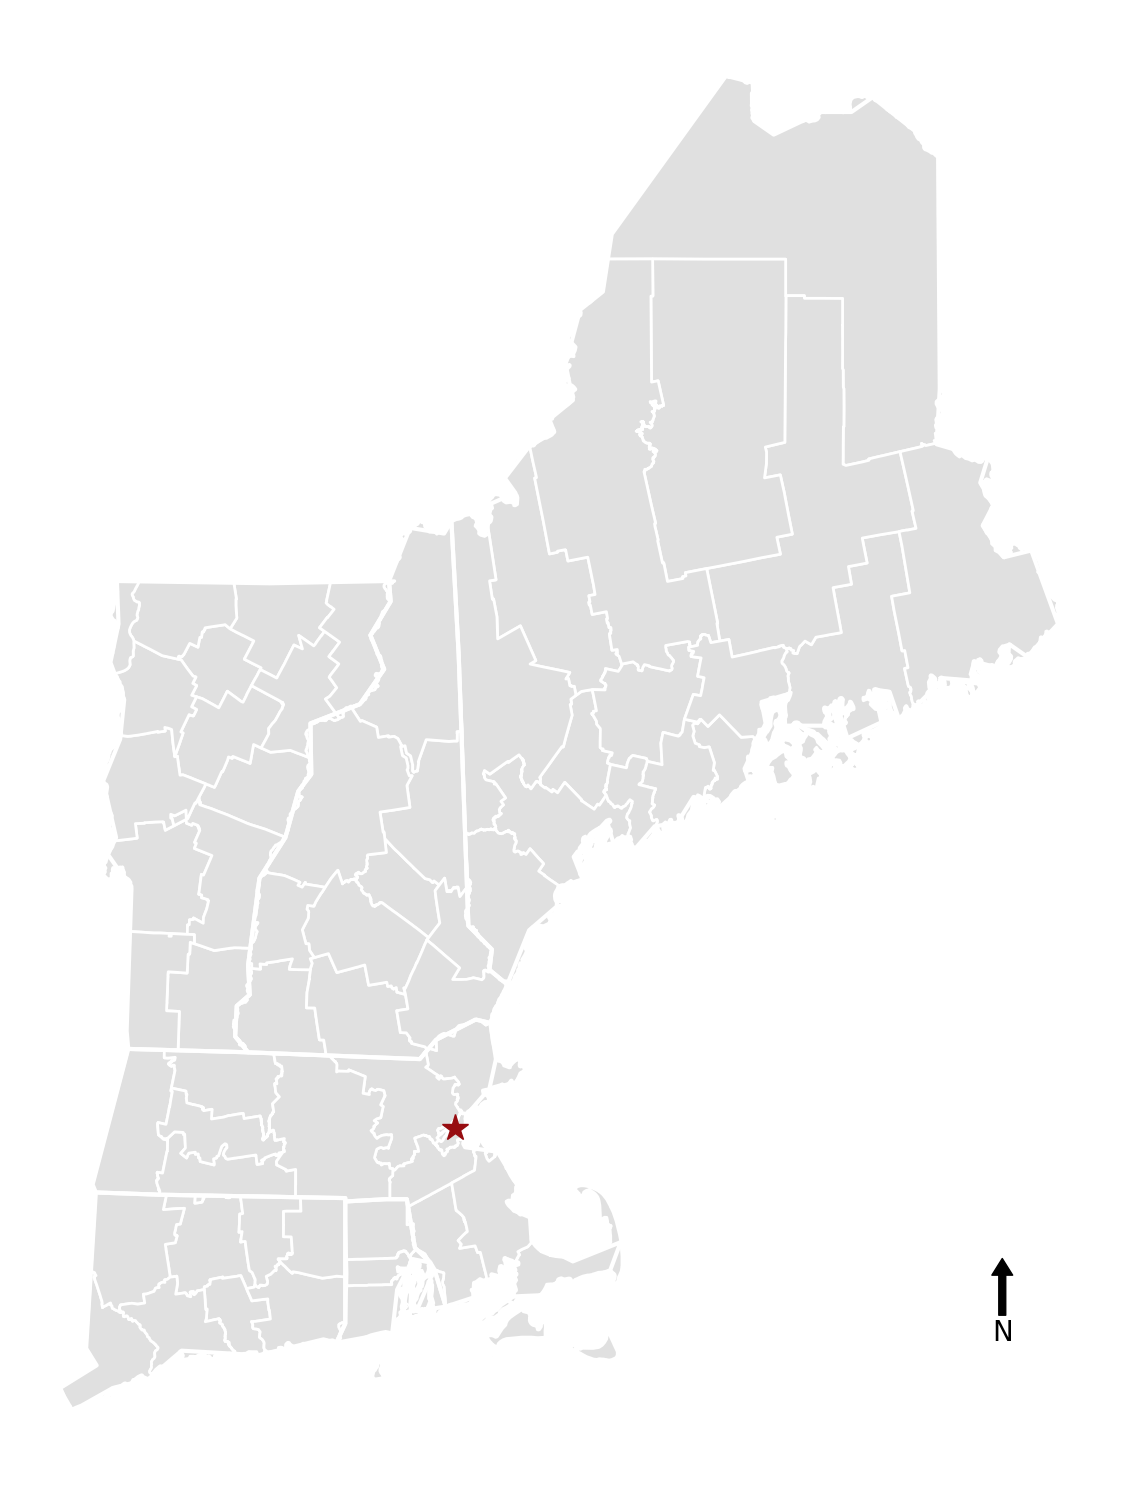

In [29]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Coordinates for Boston (latitude, longitude)
boston_coords = (-71.0589, 42.3601)  # (longitude, latitude)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plot county boundaries with gray fill and white edges
county_boundaries.plot(ax=ax, color="#e0e0e0", edgecolor="white", linewidth=2)

# Overlay state boundaries with black edges
state_boundaries.boundary.plot(ax=ax, color="white", linewidth=3)

# Add a north arrow
x, y, arrow_length = 0.9, 0.1, 0.05  # Adjust position and size
ax.annotate('N', xy=(x, y + arrow_length), xytext=(x, y),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Add a star for Boston
ax.plot(boston_coords[0], boston_coords[1], marker='*', color='#970C10', markersize=20, transform=ax.transData)

# Remove axis and annotations
ax.set_axis_off()
plt.savefig('Blank_NE_Map.svg', dpi=300, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()
